In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [44]:
import random
import shutil
import zipfile



path_cats_and_dogs = '/kaggle/input/dogs-vs-cats/train.zip'
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/source')
zip_ref.close()

In [45]:
os.mkdir('/tmp/train')
os.mkdir('/tmp/train/cats')
os.mkdir('/tmp/train/dogs')
os.mkdir('/tmp/valid')
os.mkdir('/tmp/valid/cats')
os.mkdir('/tmp/valid/dogs')

In [46]:
filenames=os.listdir('/tmp/source/train')
split_by=int(len(filenames)*0.8)
train_files=random.sample(filenames,split_by)                  
val_files = list(set(filenames)-set(train_files)) 
# Dividing images for Training and Validation 

for filename in train_files:
    if (filename[0:3]=='dog'):
        shutil.copyfile('/tmp/source/train/'+filename,'/tmp/train/dogs/'+filename)
    else:
        shutil.copyfile('/tmp/source/train/'+filename,'/tmp/train/cats/'+filename)
        
        
for filename in val_files:
    if (filename[0:3]=='dog'):
        shutil.copyfile('/tmp/source/train/'+filename,'/tmp/valid/dogs/'+filename)
    else:
        shutil.copyfile('/tmp/source/train/'+filename,'/tmp/valid/cats/'+filename)


In [47]:
print(len(os.listdir('/tmp/train/dogs')))
print(len(os.listdir('/tmp/train/cats')))

print(len(os.listdir('/tmp/valid/dogs')))
print(len(os.listdir('/tmp/valid/cats')))

10026
9974
2474
2526


# **Visualising data**

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [49]:
train_source='/tmp/source/train'
train_dir='/tmp/train'
train_cats='/tmp/train/cats'
train_dogs='/tmp/train/dogs'
valid_dir='/tmp/valid'
valid_cats='/tmp/valid/cats'
valid_dogs='/tmp/valid/dogs'



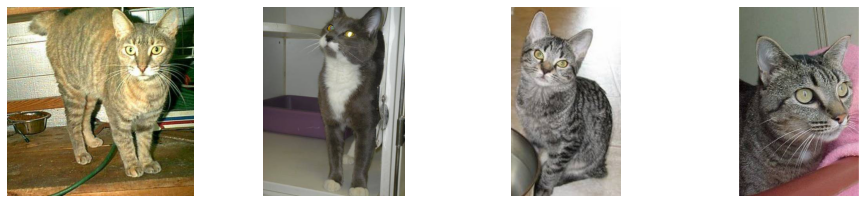

In [50]:
# Displaying 4 Random cat images 

plt.figure(figsize=(16,16))

for i,cat in enumerate(np.random.randint(0,len(os.listdir(train_cats)),4)):
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img=mpimg.imread(os.path.join(train_cats,os.listdir(train_cats)[cat]))
    fig.imshow(img)


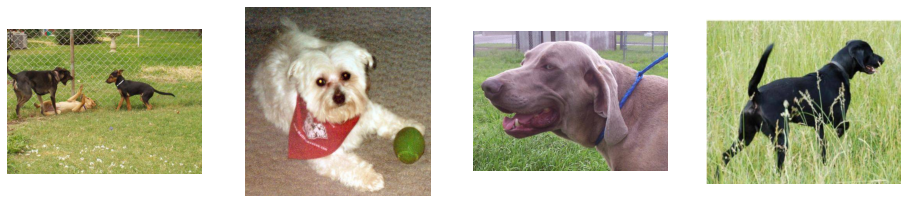

In [51]:
plt.figure(figsize=(16,16))

for i,dog in enumerate(np.random.randint(0,len(os.listdir(train_dogs)),4)):
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img=mpimg.imread(os.path.join(train_dogs,os.listdir(train_dogs)[dog]))
    fig.imshow(img)

# Build Model

In [52]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import optimizers

In [53]:
model=Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

# Data Augmentation


In [54]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    target_size=(128,128),
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(valid_dir,
                                                    batch_size=20,
                                                    target_size=(128,128),
                                                    class_mode='binary')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [55]:
img1=load_img(os.path.join(train_cats,os.listdir(train_cats)[4]))

img_data=img_to_array(img1)

samples=np.expand_dims(img_data,0)       
#Loading a single image and applying the augmentation that is applied to the whole dataset 
                                        

data_gen=ImageDataGenerator(rotation_range=15,
                            rescale=1./255,
                            shear_range=0.1,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            width_shift_range=0.1,
                            height_shift_range=0.1)
 
iterator=data_gen.flow(samples,batch_size=1)


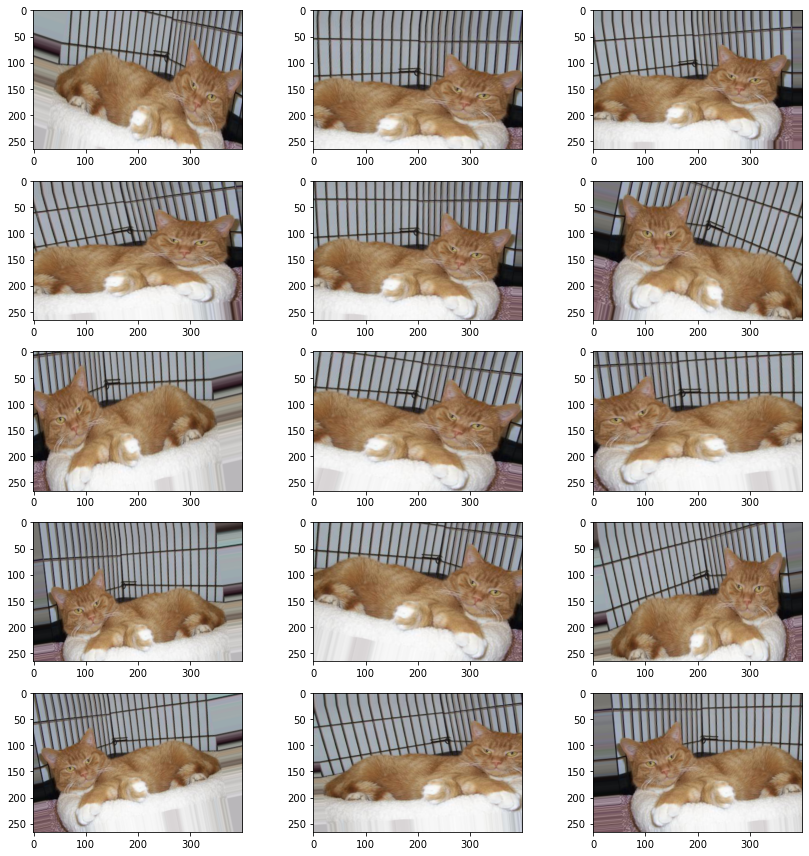

In [56]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):                  # Displaying the Augmentation Applied to every image.
    plt.subplot(5, 3, i+1)
    for X_batch in iterator:         
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()


### CallBack 
To avoid Overfitting Data

In [57]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [58]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks2 = [earlystop, learning_rate_reduction]

In [60]:
batch_size=20
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks2
     )




Epoch 1/50
1000/1000 [==============================] - 128s 128ms/step - loss: 0.5169 - accuracy: 0.7423 - val_loss: 0.6135 - val_accuracy: 0.6892
Epoch 2/50
1000/1000 [==============================] - 126s 126ms/step - loss: 0.4620 - accuracy: 0.7825 - val_loss: 0.4086 - val_accuracy: 0.8242
Epoch 3/50
1000/1000 [==============================] - 127s 127ms/step - loss: 0.4243 - accuracy: 0.8081 - val_loss: 0.9728 - val_accuracy: 0.6862
Epoch 4/50
1000/1000 [==============================] - 126s 126ms/step - loss: 0.4022 - accuracy: 0.8181 - val_loss: 0.4441 - val_accuracy: 0.7964
Epoch 5/50
1000/1000 [==============================] - 127s 127ms/step - loss: 0.3864 - accuracy: 0.8281 - val_loss: 0.4452 - val_accuracy: 0.8318
Epoch 6/50
1000/1000 [==============================] - 127s 127ms/step - loss: 0.3670 - accuracy: 0.8379 - val_loss: 0.5117 - val_accuracy: 0.7978
Epoch 7/50
1000/1000 [==============================] - 127s 127ms/step - loss: 0.3557 - accuracy: 0.8435 - val_

In [61]:
model.save_weights("model.h5")

# Visualising the Loss and Accuracy

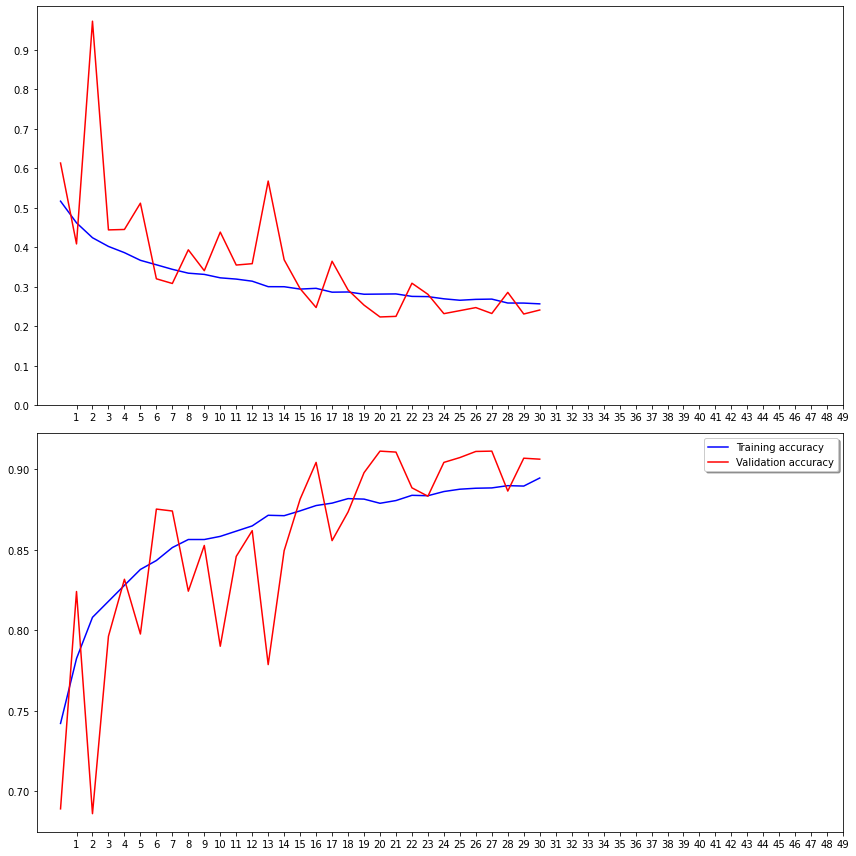

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


# Predict

In [83]:
path_test = '/kaggle/input/dogs-vs-cats/test1.zip'
local_zip = path_test
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/source')
zip_ref.close()

In [ ]:
pred = []
for pic in os.listdir('/tmp/source/test1'):
    path = '/tmp/source/test1/'+ pic
    img=load_img(path, target_size=(128, 128))

    x=img_to_array(img)
    x=np.expand_dims(x, axis=0)
    x=x/255

    pred.append(int(model.predict_classes(x)))

In [ ]:
id_ = [int(name[:-4]) for name in os.listdir('/tmp/source/test1')]
label = pred

In [ ]:
import pandas as pd
submission = pd.DataFrame({'id':id_,
             'label':pred})


In [ ]:
submission.sort_values('id',).to_csv('submission.csv',index=False)
